# Data Processing EDA

This notebook computes summary statistics and performs sanity checks on the data processing pipelines (raw_data -> relations database and sentences tagged with key terms).

In [66]:
%tb
import pandas as pd
import pickle
import json

from collections import defaultdict
import spacy

import stanfordnlp
from spacy_stanfordnlp import StanfordNLPLanguage
stanfordnlp.download('en')
snlp = stanfordnlp.Pipeline(lang="en")
nlp = StanfordNLPLanguage(snlp)

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

# fix for importing utils
import os
import sys
module_path = os.path.abspath(os.path.join('../utils'))
if module_path not in sys.path:
    sys.path.append(module_path)

data_dir = '../data/relation_extraction'

SystemExit: 1

Using the default treebank "en_ewt" for language "en".
Would you like to download the models for: en_ewt now? (Y/n)

Default download directory: /home/ubuntu/stanfordnlp_resources
Hit enter to continue or type an alternate directory.

Download location: /home/ubuntu/stanfordnlp_resources/en_ewt_models.zip


 29%|██▊       | 67.1M/235M [00:20<00:50, 3.32MB/s]


KeyboardInterrupt: 

Relation EDA:
- Programmatically ensure there are no sentences that contain a term pair that weren't tagged
- Determine any multi-labels

Double Check:
- Bi-directionality of relations
- Way that text representations are being collected

# Relations Database

In [67]:
with open("../data/relation_extraction/relations_db.json", "r") as f:
    rdb = json.load(f)

## Summary Statistics

In [68]:
long_df = {"relation": [], "term_pair": [], "count_sentences": [], "found_sentence": []}
for relation in rdb:
    for term_pair in rdb[relation]: 
        long_df["relation"].append(relation)
        long_df["term_pair"].append(term_pair)
        long_df["count_sentences"].append(len(rdb[relation][term_pair]["sentences"]))
        long_df["found_sentence"].append(len(rdb[relation][term_pair]["sentences"]) > 0)
long_df = pd.DataFrame(long_df)

In [69]:
summary_df = long_df.groupby(["relation", "found_sentence"]).agg({"term_pair": "count",
                                                                  "count_sentences": ["sum", "mean"]})
summary_df

term_pair count_sentences          
                               count             sum      mean
relation    found_sentence                                    
abuts       False                 82               0  0.000000
            True                  28             172  6.142857
element     False                408               0  0.000000
            True                  89             624  7.011236
has-part    False               3701               0  0.000000
            True                 580            4639  7.998276
has-region  False               1415               0  0.000000
            True                 146             936  6.410959
is-at       False                202               0  0.000000
            True                  44             308  7.000000
is-inside   False                494               0  0.000000
            True                 110             822  7.472727
is-outside  False                143               0  0.000000
            True                  23             185  8.043478
no-relation True              340878          836918  2.455183
possesses   False                741               0  0.000000
            True                  43             245  5.697674
subclass-of False               6078               0  0.000000
            True                 663            2149  3.241327

Relation:  no-relation


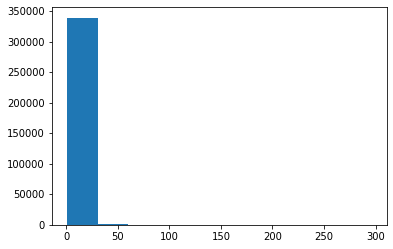

Relation:  subclass-of


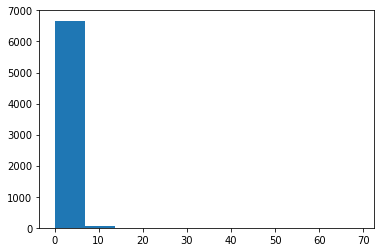

Relation:  has-part


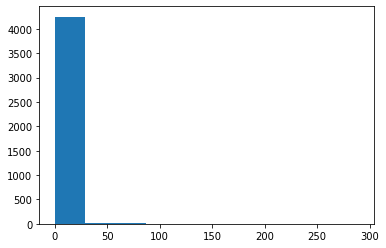

Relation:  possesses


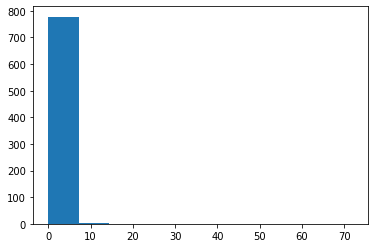

Relation:  has-region


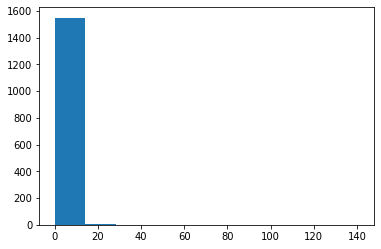

Relation:  is-inside


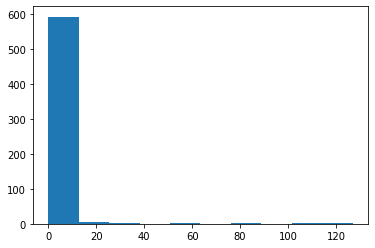

Relation:  is-at


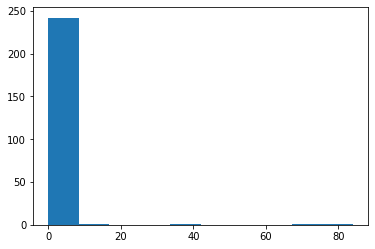

Relation:  element


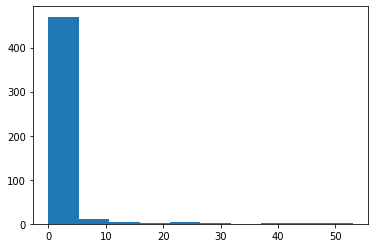

Relation:  abuts


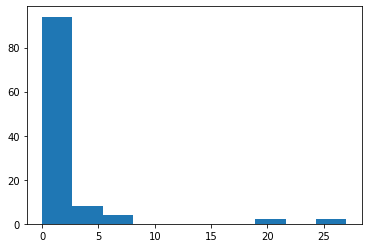

Relation:  is-outside


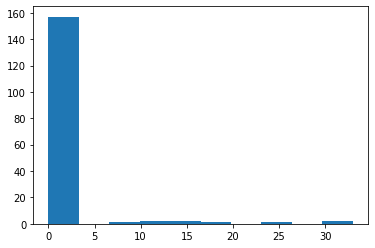

Overall


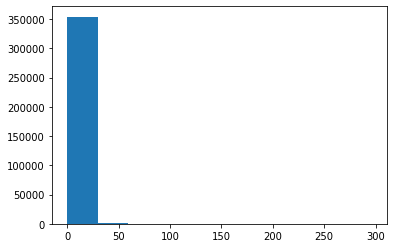

In [7]:
# Plot histogram for each relation for all word pairs
relation_grouped_df = long_df.groupby(["relation"])
for relation in rdb:
    sentences_count = relation_grouped_df.get_group(relation)["count_sentences"]
    print("Relation: ", relation)
    plt.hist(list(sentences_count))
    plt.show()
    
# Overall histogram distribution
print("Overall")
plt.hist(list(long_df["count_sentences"]))
plt.show()

Relation:  no-relation


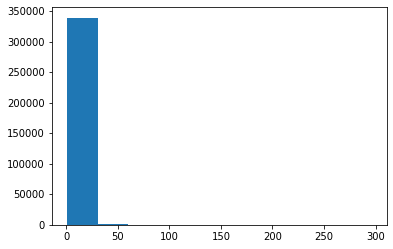

Relation:  subclass-of


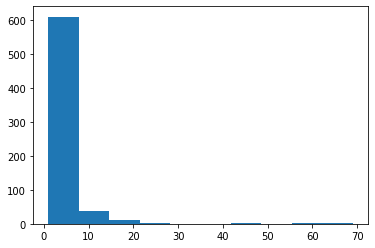

Relation:  has-part


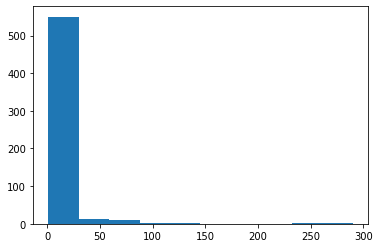

Relation:  possesses


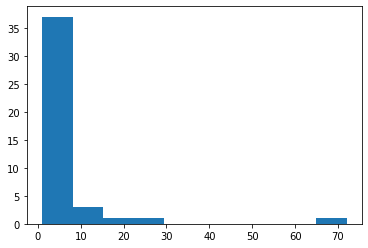

Relation:  has-region


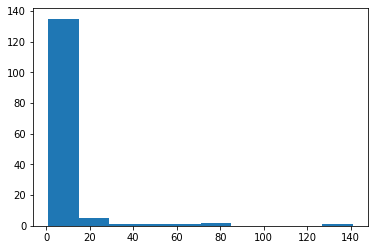

Relation:  is-inside


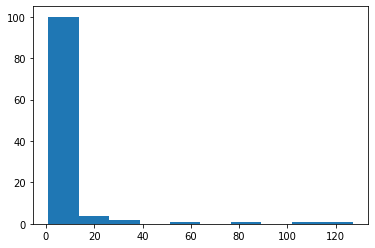

Relation:  is-at


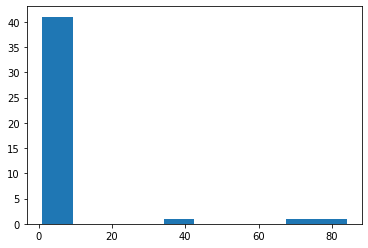

Relation:  element


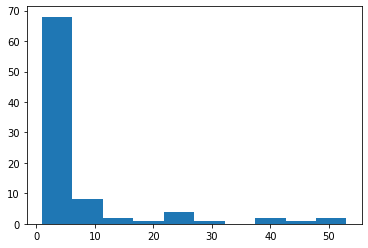

Relation:  abuts


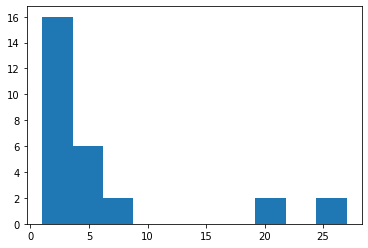

Relation:  is-outside


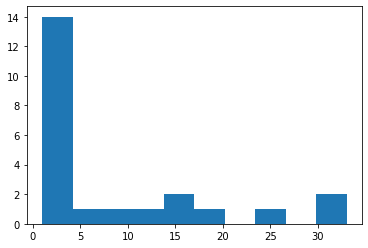

In [5]:
# Plot histogram for each relation for only found sentences
relation_grouped_df = long_df.groupby(["relation", "found_sentence"])
for relation in rdb:
    sentences_count = relation_grouped_df.get_group((relation, True))["count_sentences"]
    print("Relation: ", relation)
    plt.hist(list(sentences_count))
    plt.show()

## Multi-Label Term Pairs

In [70]:
term_relation_mapping = {}
for relation in rdb:
    for tp in rdb[relation]:
        if tp in term_relation_mapping:
            term_relation_mapping[tp].append(relation)
        else:
            term_relation_mapping[tp] = [relation]
multi_label = {tp:r for tp, r in term_relation_mapping.items() if len(r) > 1}
print(len(multi_label))
multi_label

87


{'mixture -> substance': ['subclass-of', 'has-part'],
 'membrane -> membrane': ['subclass-of', 'is-at'],
 'segment of body -> anatomical structure': ['subclass-of', 'has-part'],
 'bone -> connective tissue': ['subclass-of', 'has-part'],
 'CDNA -> dna': ['subclass-of', 'abuts'],
 'circular dna -> dna': ['subclass-of', 'has-part'],
 'diet -> object': ['subclass-of', 'element'],
 'gene -> dna sequence': ['subclass-of', 'has-part'],
 'glycosidic linkage -> polar covalent bond': ['subclass-of', 'element'],
 'homeodomain -> protein domain': ['subclass-of', 'has-region'],
 'hydrophobic core -> hydrophobic region': ['subclass-of', 'abuts'],
 'nucleic acid probe -> nucleic acid strand': ['subclass-of', 'has-part'],
 'polymer -> chemical': ['subclass-of', 'has-part'],
 'proteasome -> protein': ['subclass-of', 'has-part'],
 'seed -> tissue': ['subclass-of', 'has-part'],
 'substance -> object': ['subclass-of', 'has-part'],
 'trimer -> molecule': ['subclass-of', 'has-part'],
 'variable domain -> pr

**Plot distribution of sentences**

## Sanity Checks

- How many word-pairs match the text on regex, but we don't match in the pipeline?
- How many word-pairs don't match sentences? Do these seem reasonable?
- Word-pairs with too many matches?


How many terms actually match the text?

In [71]:
bio_sentences = pd.read_csv("../data/raw_data/openstax/sentences_Biology_2e_parsed.csv")
EXCLUDE_SECTIONS = [
    "Preface", "Chapter Outline", "Index", "Chapter Outline", "Summary", "Multiple Choice",
    "Fill in the Blank", "short Answer", "Critical Thinking", "References", 
    "Units", "Conversion Factors", "Fundamental Constants", "Astronomical Data",
    "Mathematical Formulas", "The Greek Alphabet", "Chapter 1", "Chapter 2",
    "Chapter 3", "Chapter 4", "Chapter 5", "Chapter 6", "Chapter 7", "Chapter 8"
    "Chapter 9", "Chapter 10", "Chapter 11", "Chapter 12", "Chapter 13", "Chapter 14", 
    "Chapter 15", "Chapter 16", "Chapter 17", "Critical Thinking Questions", 
    "Visual Connection Questions", "Key Terms", "Review Questions", 
    "The Periodic Table of Elements", "Measurements and the Metric System"]
bio_sentences = bio_sentences[~bio_sentences.section_name.isin(EXCLUDE_SECTIONS)]

count = 0

high_matches = {}
no_match_in_text = {}
no_match_not_in_text = {}

for relation in rdb:
    if relation == "no-relation":
        continue
    for term_pair in rdb[relation]:
        
        count_sentences = len(rdb[relation][term_pair]["sentences"])
        
        if count_sentences > 10:
            high_matches[term_pair] = rdb[relation][term_pair]
            high_matches[term_pair]["relation"] = relation
        if not count_sentences:
            terms = term_pair.split(" -> ")
            # exclude terms that are subsets of one another
            if terms[0] in terms[1] or terms[1] in terms[0]:
                continue
            term_sentences = list(bio_sentences[(bio_sentences.sentence.str.contains(terms[0])) & 
                                                (bio_sentences.sentence.str.contains(terms[1]))].sentence)
            if len(term_sentences):
                no_match_in_text[term_pair] = rdb[relation][term_pair]
                no_match_in_text[term_pair]["textbook_sentences"] = term_sentences
                no_match_in_text[term_pair]["relation"] = relation 
            else:
                no_match_not_in_text[term_pair] = rdb[relation][term_pair]
                no_match_not_in_text[term_pair]["relation"] = relation 

In [72]:
print(f"{len(no_match_in_text)} term pairs had no tagged relations but matched text")
print(f"{len(no_match_not_in_text)} term pairs had no tagged relations and no matched text")
print(f"{len(high_matches)} term pairs had more than 10 matched sentences")

355 term pairs had no tagged relations but matched text
11462 term pairs had no tagged relations and no matched text
176 term pairs had more than 10 matched sentences


In [57]:
for term in list(no_match_not_in_text.keys())[:20]:
    print(no_match_not_in_text[term])

{'sentences': [], 'e1_representations': ['chemical'], 'e2_representations': ['object'], 'relation': 'subclass-of'}
{'sentences': [], 'e1_representations': ['mixture'], 'e2_representations': ['substance'], 'relation': 'has-part'}
{'sentences': [], 'e1_representations': ['aggregate'], 'e2_representations': ['object'], 'relation': 'subclass-of'}
{'sentences': [], 'e1_representations': ['region'], 'e2_representations': ['object'], 'relation': 'subclass-of'}
{'sentences': [], 'e1_representations': ['community'], 'e2_representations': ['aggregate'], 'relation': 'subclass-of'}
{'sentences': [], 'e1_representations': ['animate thing'], 'e2_representations': ['object'], 'relation': 'subclass-of'}
{'sentences': [], 'e1_representations': ['animate thing'], 'e2_representations': ['organic entity'], 'relation': 'subclass-of'}
{'sentences': [], 'e1_representations': ['information'], 'e2_representations': ['conceptual entity'], 'relation': 'subclass-of'}
{'sentences': [], 'e1_representations': ['conc

In [73]:
for term in list(no_match_in_text.keys())[:20]:
    print(term)
    print(no_match_in_text[term]["textbook_sentences"])
    print()

role -> thing
['By the end of this section, you will be able to do the following:    Describe the role of cells in organisms   Compare and contrast light microscopy and electron microscopy   Summarize cell theory       A cell is the smallest unit of a living thing.']

active transport -> transport work
['Recall the active transport work of the sodium-potassium pump in cell membranes.']

adaptive immunity -> immune response
['By the end of this section, you will be able to do the following:    Explain adaptive immunity   Compare and contrast adaptive and innate immunity   Describe cell-mediated immune response and humoral immune response   Describe immune tolerance       The adaptive, or acquired, immune response takes days or even weeks to become established—much longer than the innate response; however, adaptive immunity is more specific to pathogens and has memory.']

alga -> Streptophyta
['The Major Divisions of Land Plants   The green algae and land plants are grouped together into

In [58]:
for term in list(high_matches.keys())[:20]:
    print(high_matches[term]["e1_representations"])
    print(high_matches[term]["e2_representations"])
    print()

['chemical', 'chemicals']
['substance', 'substances']

['activation energy']
['energy']

['allele', 'alleles']
['gene', 'genes']

['atom', 'atoms']
['chemical']

['bird', 'birds']
['vertebrate', 'vertebrates']

['blood']
['connective tissue', 'connective tissues']

['bone', 'bones']
['connective tissue', 'connective tissues']

['cancer', 'cancers']
['disease', 'diseases']

['compound', 'compounds']
['chemical', 'chemicals']

['concentration gradient', 'concentration gradients']
['gradient', 'gradients']

['connective tissue', 'connective tissues']
['tissue', 'tissues']

['ectoderm']
['germ layer', 'germ layers']

['endoskeleton', 'endoskeletons']
['skeleton', 'skeletons']

['glycoprotein', 'glycoproteins']
['protein', 'proteins']

['molecule', 'molecules']
['chemical', 'chemicals']

['monomer', 'monomers']
['molecule', 'molecules']

['nucleus']
['organelle', 'organelles']

['outer membrane', 'outer membranes']
['membrane', 'membranes']

['plant', 'plants']
['eukaryote', 'eukaryotes']

